# Text Classification using word/sentence vectors and different Classifiers

In [1]:
# import libraries
import fasttext
import time
import json
import gzip
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [2]:
# import self trained vectors
# vectors were trained on book descriptions and review text
model_vec = fasttext.load_model('emb_model.vec')

In [3]:
#generator to open json.gzip files
# yields single lines
def get_reviews(file):
    '''
    Generator will yield lines of the passed file
    '''
    with gzip.open(file, 'r') as f:
        for l in f:
            yield l
    f.close()
# fetch features
def fetch_features(file, features):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a dictionary.
    file: json.gzip file you want to scan
    features: features to extract from data
    only reviews written in english will be collected
    '''
    
    feature_dict = defaultdict(list)    
    reviews = get_reviews(file)
    
    for review in tqdm(reviews):
        review_dict = json.loads(review)
        language = review_dict.get('review_language_start')

        if language != 'en': 
            continue
        
        else:
            for f in features:
                feature_dict[f].append(review_dict.get(f))
        
        
    return pd.DataFrame.from_dict(feature_dict)


In [4]:
training = 'train_set_text_edit.json.gz'
validation = 'validation_set_text_edit.json.gz'
test = 'test_set_text_edit.json.gz'

In [6]:
features = ['has_spoiler','sentence_labels', 'sentence_text_spellchecked', 'lemmatized', 'best_genre']
df_train = fetch_features(training, features)

964623it [03:24, 4725.94it/s]


In [7]:
df_train.head()

,has_spoiler,sentence_labels,sentence_text_spellchecked,lemmatized,best_genre
0,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[read this review on my blog, , definitely bet...","[read review blog, , definitely well book, ins...",young-adult
1,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[i was writing a comment that i realized would...,[write comment realize probably end long quali...,fiction
2,False,"[0, 0, 0, 0]",[charlie is turning and her younger sister is ...,"[charlie turn young sister get marry, decide w...",romance
3,False,"[0, 0, 0, 0]",[is more like it even though this has got to b...,[like get implausible storyline read long time...,romance
4,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[review originally posted at step into fiction...,"[review originally post step fiction, want reb...",young-adult


In [111]:
from sklearn.model_selection import train_test_split
random_state = 42

X=df_train['sentence_text_spellchecked'].apply(lambda x: ' '.join(x))
y = df_train['has_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = random_state, stratify= y)

## Text Vectorization

In [9]:
# dimension of word vectors
print(model_vec.get_dimension())

100


In [10]:
# get sentence vectors for reviews
list_of_sent_vec = []
for sentence in tqdm(X_train):
    vec = model_vec.get_sentence_vector(sentence)
    list_of_sent_vec.append(vec)

    
    

100%|██████████| 670271/670271 [07:08<00:00, 1563.72it/s]


In [11]:
list_col = tuple(range(100))
df_vec = pd.DataFrame(data =list_of_sent_vec, columns = list_col )

In [12]:
df_vec.shape

(670271, 100)

In [13]:
from sklearn import metrics
from sklearn.model_selection import cross_validate

from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier 
#import xgboost as xgb
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier

In [14]:
models2 = dict()
random_state = 42
models2['SGD'] = SGDClassifier(n_jobs = -1)
models2['LinearSVC'] = LinearSVC(random_state=random_state, max_iter = 5000) 
models2['LogReg'] = LogisticRegression(n_jobs=-1, random_state=random_state)
models2['KNN'] = KNeighborsClassifier()
models2['Ridge'] = RidgeClassifier(random_state=random_state)
models2['D_Tree_CLF'] = DecisionTreeClassifier(max_depth = 50, random_state=random_state)
models2['Perceptron'] = Perceptron(n_jobs = -1)
models2['PA_CLF'] = PassiveAggressiveClassifier(n_jobs = -1)
models2['ExtraTree'] = ExtraTreesClassifier(max_depth = 50)
models2['RandomForrest'] = RandomForestClassifier()
models2['Bagging_LR'] = BaggingClassifier(base_estimator =LogisticRegression(), n_estimators = 20 )
models2['Bagging_Tree'] = BaggingClassifier(base_estimator =DecisionTreeClassifier(max_depth = 20), n_estimators = 10 )
models2['Adaboost_LR'] = AdaBoostClassifier(base_estimator =LogisticRegression())
models2['Adaboost_Tree'] = AdaBoostClassifier()

In [15]:
def test_clfs(models, X_train, y_train, cv = 5):
    classifier = []
    recall = []
    precision = []
    roc_auc = []
    f1_macro = []
    fit_time = []
    accuracy = []
    
    for name, clf in (models.items()):
        scores = cross_validate(clf, X_train, y_train, scoring = ['recall', 'accuracy', 'precision', 'f1_macro', 'roc_auc'], 
                                 cv = cv)
        classifier.append(clf)
        
        fit_time.append(f"{round(np.mean(scores['fit_time']),3)} +/- {round(np.std(scores['fit_time']),3)}")
        recall.append(f"{round(np.mean(scores['test_recall']),3)} +/- {round(np.std(scores['test_recall']),3)}")
        precision.append(f"{round(np.mean(scores['test_precision']),3)} +/- {round(np.std(scores['test_precision']),3)}")
        roc_auc.append(f"{round(np.mean(scores['test_roc_auc']),3)} +/- {round(np.std(scores['test_roc_auc']),3)}")
        f1_macro.append(f"{round(np.mean(scores['test_f1_macro']),3)} +/- {round(np.std(scores['test_f1_macro']),3)}")
        accuracy.append(f"{round(np.mean(scores['test_accuracy']),3)} +/- {round(np.std(scores['test_accuracy']),3)}")
        
        print(f'Done with {name}')
        
    classification_result = pd.DataFrame({
        'classifier':classifier,
        'fit_time': fit_time,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'roc_auc': roc_auc,
        'f1_macro': f1_macro})
    return classification_result

In [75]:
# also test imbalance classifiers from imblearn
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier,RUSBoostClassifier

models_imblearn = {}

models_imblearn['BalancedRandomForestClassifier'] = BalancedRandomForestClassifier()
models_imblearn['Bagging-SVC'] = BalancedBaggingClassifier(base_estimator= LinearSVC())
#models_imblearn['Bagging-KNN'] = BalancedBaggingClassifier(base_estimator= KNeighborsClassifier())
models_imblearn['Bagging-Logistic'] = BalancedBaggingClassifier(base_estimator= LogisticRegression())
#models_imblearn['Bagging-Tree'] = BalancedBaggingClassifier(base_estimator= DecisionTreeClassifier())
models_imblearn['Bagging-Ridge'] = BalancedBaggingClassifier(base_estimator= RidgeClassifier())
models_imblearn['RUSBoost'] = RUSBoostClassifier()
models_imblearn['RUSBoost_LogReg'] = RUSBoostClassifier(base_estimator= LogisticRegression())


In [73]:
test_clfs(models2, df_vec, y_train)

  0%|          | 0/14 [00:00<?, ?it/s]/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklea

Done with SGD


 14%|█▍        | 2/14 [01:31<06:30, 32.55s/it]

Done with LinearSVC


 21%|██▏       | 3/14 [23:16<1:15:55, 414.16s/it]

Done with LogReg


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 29%|██▊       | 4/14 [23:28<48:55, 293.56s/it]  

Done with Ridge


 36%|███▌      | 5/14 [34:09<59:41, 397.90s/it]

Done with D_Tree_CLF


 43%|████▎     | 6/14 [34:19<37:31, 281.42s/it]

Done with Perceptron


 50%|█████     | 7/14 [34:29<23:21, 200.20s/it]

Done with PA_CLF


 57%|█████▋    | 8/14 [50:31<42:51, 428.54s/it]

Done with ExtraTree


 64%|██████▍   | 9/14 [1:53:24<1:59:19, 1431.81s/it]

Done with RandomForrest


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

Done with Bagging_LR


 79%|███████▊  | 11/14 [3:09:06<1:38:48, 1976.12s/it]

Done with Bagging_Tree


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: Un

Done with XGBoost


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: Un

Done with Adaboost_LR


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: Un

Done with Adaboost_Tree


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,SGDClassifier(n_jobs=-1),2.279 +/- 0.607,0.935 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.761 +/- 0.002,0.483 +/- 0.0
1,"LinearSVC(max_iter=5000, random_state=42)",15.515 +/- 0.49,0.934 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.768 +/- 0.001,0.483 +/- 0.0
2,"LogisticRegression(n_jobs=-1, random_state=42)",260.413 +/- 19.064,0.934 +/- 0.0,0.0 +/- 0.0,0.023 +/- 0.011,0.762 +/- 0.001,0.483 +/- 0.0
3,RidgeClassifier(random_state=42),2.134 +/- 0.319,0.935 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.759 +/- 0.001,0.483 +/- 0.0
4,"DecisionTreeClassifier(max_depth=50, random_st...",127.962 +/- 6.832,0.874 +/- 0.001,0.166 +/- 0.003,0.131 +/- 0.002,0.544 +/- 0.001,0.539 +/- 0.001
5,Perceptron(n_jobs=-1),1.691 +/- 0.075,0.798 +/- 0.134,0.378 +/- 0.327,0.131 +/- 0.049,0.76 +/- 0.002,0.515 +/- 0.036
6,PassiveAggressiveClassifier(n_jobs=-1),1.912 +/- 0.078,0.854 +/- 0.16,0.175 +/- 0.349,0.039 +/- 0.041,0.763 +/- 0.001,0.473 +/- 0.02
7,ExtraTreesClassifier(max_depth=50),180.813 +/- 0.68,0.935 +/- 0.0,0.004 +/- 0.001,0.992 +/- 0.016,0.798 +/- 0.002,0.487 +/- 0.001
8,RandomForestClassifier(),745.914 +/- 5.133,0.935 +/- 0.0,0.004 +/- 0.0,0.924 +/- 0.007,0.772 +/- 0.001,0.487 +/- 0.0
9,BaggingClassifier(base_estimator=LogisticRegre...,193.574 +/- 2.8,0.934 +/- 0.0,0.0 +/- 0.0,0.02 +/- 0.009,0.762 +/- 0.001,0.483 +/- 0.0


These results suggest that the approach is not working. Try imbalanced learners from imblearn. 
 

In [17]:
test_clfs(models_imblearn, df_vec, y_train)

Done with BalancedRandomForestClassifier
Done with Bagging-SVC


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Done with Bagging-Logistic
Done with Bagging-Ridge
Done with RUSBoost


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/ensemble/_weight_boosting.py", line 170, in fit
    super().fit(X, y, sample_weight)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py", line 117, in fit
    self._validate_estimator()
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/ensemble/_weight_boosting.py", line 176, in _validate_estimator
    super()._validat

Done with RUSBoost_SVC
Done with RUSBoost_LogReg


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,BalancedRandomForestClassifier(),151.631 +/- 25.108,0.721 +/- 0.001,0.763 +/- 0.006,0.159 +/- 0.001,0.816 +/- 0.002,0.546 +/- 0.001
1,BalancedBaggingClassifier(base_estimator=Linea...,66.292 +/- 7.975,0.649 +/- 0.001,0.769 +/- 0.005,0.13 +/- 0.0,0.769 +/- 0.001,0.498 +/- 0.0
2,BalancedBaggingClassifier(base_estimator=Logis...,46.306 +/- 0.754,0.644 +/- 0.001,0.763 +/- 0.005,0.128 +/- 0.0,0.763 +/- 0.002,0.495 +/- 0.0
3,BalancedBaggingClassifier(base_estimator=Ridge...,34.475 +/- 5.674,0.631 +/- 0.002,0.784 +/- 0.005,0.126 +/- 0.0,0.764 +/- 0.002,0.488 +/- 0.001
4,RUSBoostClassifier(),100.639 +/- 4.929,0.668 +/- 0.002,0.794 +/- 0.003,0.14 +/- 0.001,0.802 +/- 0.002,0.513 +/- 0.001
5,RUSBoostClassifier(base_estimator=LinearSVC()),0.45 +/- 0.021,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan
6,RUSBoostClassifier(base_estimator=LogisticRegr...,29.131 +/- 1.845,0.794 +/- 0.002,0.294 +/- 0.009,0.107 +/- 0.002,0.689 +/- 0.002,0.52 +/- 0.001


In [60]:
from sklearn.metrics import classification_report
# test on test data
clf = RUSBoostClassifier()
clf.fit(df_vec, y_train)

# vectorize X_test data
X_test_vec = []
for sentence in tqdm(X_test):
    vec = model_vec.get_sentence_vector(sentence)
    X_test_vec.append(vec)

prediction = clf.predict(X_test_vec)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       False       0.98      0.66      0.79    208817
        True       0.14      0.79      0.24     14607

    accuracy                           0.67    223424
   macro avg       0.56      0.73      0.51    223424
weighted avg       0.92      0.67      0.75    223424



The results are similar to other classification approaches we have used in this project.

In [19]:
# built a downsampled no spoiler dataset
df_spoiler = df_train[df_train['has_spoiler']==1]

In [22]:
genre_counts = np.unique(df_spoiler.best_genre, return_counts = True)

In [23]:
df_genre_spoiler = pd.DataFrame({
    'genre': genre_counts[0],
    'count': genre_counts[1]
})
df_genre_spoiler

,genre,count
0,children,403
1,"comics, graphic",1348
2,"fantasy, paranormal",20992
3,fiction,9448
4,"history, historical fiction, biography",877
5,"mystery, thriller, crime",3633
6,non-fiction,353
7,poetry,24
8,romance,10079
9,young-adult,11271


In [61]:
# get 3x the number of safe reviews (compared to )
df_safe = df_train[df_train['has_spoiler']==0]
num_genre = df_genre_spoiler.shape[0] #number of genres

#create empty dataframe to be filled with safe data
df = pd.DataFrame(columns = df_safe.columns)

for i in range(num_genre): 
    df_add = df_safe[df_safe['best_genre']==df_genre_spoiler['genre'][i]].sample(n = df_genre_spoiler['count'][i]*3,
                                                                                random_state = random_state)
    df = pd.concat([df, df_add])



In [73]:
# test if df contains correct count of genres
genre_counts_safe = np.unique(df.best_genre, return_counts = True)
(genre_counts_safe[1] == df_genre_spoiler['count'].values*3).all()

True

In [74]:
# put data together and resample
df_downsampled = pd.concat([df_spoiler, df], ignore_index = True).sample(frac = 1,random_state = random_state)

In [110]:
# vectorize reviews of downsampled dataset
y_train_d = df_downsampled['has_spoiler'].astype('int')
X_train_downsampled = df_downsampled['sentence_text_spellchecked'].apply(lambda x: ' '.join(x))
X_train_downsampled_vec = []

for sentence in tqdm(X_train_downsampled):
    vec = model_vec.get_sentence_vector(sentence)
    X_train_downsampled_vec.append(vec)
X_train_downsampled_vec = pd.DataFrame(data = X_train_downsampled_vec, columns = list_col)

# test classifiers
test_clfs(models_imblearn, X_train_downsampled_vec, y_train_d)

100%|██████████| 233712/233712 [02:45<00:00, 1408.51it/s]


Done with BalancedRandomForestClassifier
Done with Bagging-SVC


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Done with Bagging-Logistic
Done with Bagging-Ridge
Done with RUSBoost
Done with RUSBoost_LogReg


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,BalancedRandomForestClassifier(),231.42 +/- 9.123,0.725 +/- 0.001,0.764 +/- 0.006,0.47 +/- 0.001,0.814 +/- 0.002,0.689 +/- 0.001
1,BalancedBaggingClassifier(base_estimator=Linea...,54.623 +/- 0.686,0.672 +/- 0.002,0.769 +/- 0.002,0.416 +/- 0.002,0.769 +/- 0.001,0.642 +/- 0.001
2,BalancedBaggingClassifier(base_estimator=Logis...,43.261 +/- 0.739,0.668 +/- 0.002,0.761 +/- 0.002,0.411 +/- 0.002,0.764 +/- 0.001,0.638 +/- 0.001
3,BalancedBaggingClassifier(base_estimator=Ridge...,17.342 +/- 0.408,0.661 +/- 0.002,0.782 +/- 0.003,0.407 +/- 0.002,0.764 +/- 0.001,0.634 +/- 0.002
4,RUSBoostClassifier(),124.366 +/- 0.61,0.689 +/- 0.002,0.798 +/- 0.006,0.434 +/- 0.001,0.801 +/- 0.002,0.66 +/- 0.001
5,RUSBoostClassifier(base_estimator=LogisticRegr...,23.402 +/- 0.438,0.625 +/- 0.002,0.673 +/- 0.004,0.365 +/- 0.002,0.688 +/- 0.003,0.591 +/- 0.002


In [124]:
clf2 = RUSBoostClassifier()
clf2.fit(X_train_downsampled_vec, y_train_d)

RUSBoostClassifier()

In [125]:
# predict test data and evaluate with classifification report
prediction2 = clf3.predict(X_test_vec)
print(classification_report(y_test, prediction2))

              precision    recall  f1-score   support

       False       0.98      0.66      0.79    208817
        True       0.14      0.80      0.24     14607

    accuracy                           0.67    223424
   macro avg       0.56      0.73      0.51    223424
weighted avg       0.92      0.67      0.75    223424



In [117]:
probabilities_test

array([[0.51128483, 0.48871517],
       [0.51597307, 0.48402693],
       [0.51558383, 0.48441617],
       ...,
       [0.50176084, 0.49823916],
       [0.49406977, 0.50593023],
       [0.4956561 , 0.5043439 ]])

In [126]:
# predict probabilities
probabilities_test = clf2.predict_proba(X_test_vec)
proba_spoiler = [proba[1] for proba in probabilities_test]

ROC-AUC score = 0.8047108238114926


Text(0, 0.5, 'recall')

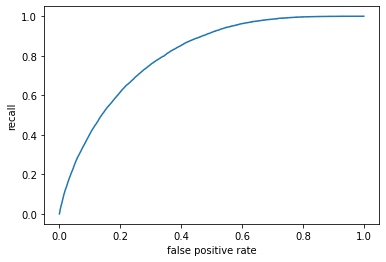

In [121]:
# roc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

fpr, tpr, threshold = roc_curve(y_test, proba_spoiler)


print(f"ROC-AUC score = {roc_auc_score(y_test, proba_spoiler)}")

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('recall') 

Text(0, 0.5, 'precision')

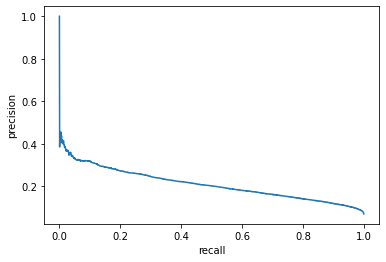

In [123]:
precision, recall, t = precision_recall_curve(y_test, proba_spoiler)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision') 

The recall is quite good, but the precision is still bad. Try to optimize later. 

In [132]:
#predict probas using under sampled and all test data for training data
# get vectors for all training data
list_of_sent_vec = []
for sentence in tqdm(X):
    vec = model_vec.get_sentence_vector(sentence)
    list_of_sent_vec.append(vec)

list_col = tuple(range(100))
df_vec_X = pd.DataFrame(data =list_of_sent_vec, columns = list_col )


predict_train_all = clf.predict_proba(df_vec_X)
predict_train_all_spoiler = [proba[1] for proba in predict_train_all]
predict_train_undersampled = clf2.predict_proba(df_vec_X)
predict_train_all_undersampled = [proba[1] for proba in predict_train_undersampled]

100%|██████████| 893695/893695 [08:16<00:00, 1799.53it/s]


In [134]:
df_vectors_probabilities = pd.DataFrame({
    'vector_all':predict_train_all_spoiler,
    'vector_downsampled':predict_train_all_undersampled
})
df_vectors_probabilities.to_csv('train_embedding_vector_probabilities.csv')

In [135]:
# also predict for test data
df_test = fetch_features(test, features)
X_test = df_test['sentence_text_spellchecked'].apply(lambda x: ' '.join(x))

list_of_sent_vec = []
for sentence in tqdm(X_test):
    vec = model_vec.get_sentence_vector(sentence)
    list_of_sent_vec.append(vec)

list_col = tuple(range(100))
df_vec_X_test = pd.DataFrame(data =list_of_sent_vec, columns = list_col )

predict_test_all = clf.predict_proba(df_vec_X_test)
predict_test_all_spoiler = [proba[1] for proba in predict_test_all]
predict_test_undersampled = clf2.predict_proba(df_vec_X_test)
predict_test_all_undersampled = [proba[1] for proba in predict_test_undersampled]

df_vectors_probabilities_test = pd.DataFrame({
    'vector_all':predict_test_all_spoiler,
    'vector_downsampled':predict_test_all_undersampled
})
df_vectors_probabilities_test.to_csv('test_embedding_vector_probabilities.csv')

137804it [00:29, 4653.15it/s]
100%|██████████| 127592/127592 [01:43<00:00, 1233.70it/s]


## Classification using pretrained word vectors

Here we will repeat the steps from above but use vectors trained on a much larger corpus. Also, we will focus on only one genre (crime) to reduce computing time.

In [6]:
# download model
import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore');  # English
ft = fasttext.load_model('cc.en.300.bin')

In [23]:
# as the pretrained embedding vectors have a dimension of 300 we will set up the dataframe as follows
# first test with a genre specific datase
df_crime = df_train[df_train['best_genre']=='mystery, thriller, crime']
df_crime['lemmatized'] = df_crime['lemmatized'].apply(lambda x: ' '.join(x))
df_train_vec = pd.DataFrame(columns = range(300))
for review in tqdm(df_crime['lemmatized']):
    vec = ft.get_sentence_vector(review)
    df_train_vec = df_train_vec.append(pd.Series(vec), ignore_index=True )

<ipython-input-23-a0ffe2bfbcac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crime['lemmatized'] = df_crime['lemmatized'].apply(lambda x: ' '.join(x))
100%|██████████| 48194/48194 [14:32<00:00, 55.21it/s] 


In [38]:
print(df_crime.shape)
print(df_train_vec.shape)

(48194, 4)
(48194, 300)


In [39]:
df_train_vec.to_csv('crime_reviews_vectors.csv')

In [40]:
df_crime.to_json('crime_reviews.json')

In [164]:
# import, initiate and put standard classifiers into a dictionary
from sklearn.neighbors import KNeighborsClassifier
random_state = 42

models2 = dict()
models2['SGD'] = SGDClassifier(n_jobs = -1)
models2['LinearSVC'] = LinearSVC(random_state=random_state, max_iter = 5000) 
models2['LogReg'] = LogisticRegression(n_jobs=-1, random_state=random_state)
#models2['MultinomialNB'] = MultinomialNB(alpha = 1e-6)
#models2['Ridge'] = RidgeClassifier(random_state=random_state)
models2['D_Tree_CLF'] = DecisionTreeClassifier(max_depth = 50, random_state=random_state)
#models2['KNN'] = KNeighborsClassifier()


In [165]:
test_clfs(models2,df_train_vec, df_crime['has_spoiler'] )

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision 

Done with SGD


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done with LinearSVC
Done with LogReg
Done with D_Tree_CLF


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,SGDClassifier(n_jobs=-1),0.695 +/- 0.186,0.925 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.76 +/- 0.008,0.48 +/- 0.0
1,"LinearSVC(max_iter=5000, random_state=42)",3.022 +/- 0.746,0.924 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.767 +/- 0.008,0.48 +/- 0.0
2,"LogisticRegression(n_jobs=-1, random_state=42)",15.241 +/- 0.789,0.924 +/- 0.0,0.0 +/- 0.001,0.029 +/- 0.057,0.753 +/- 0.007,0.481 +/- 0.001
3,"DecisionTreeClassifier(max_depth=50, random_st...",21.322 +/- 0.745,0.854 +/- 0.002,0.175 +/- 0.013,0.136 +/- 0.01,0.542 +/- 0.007,0.537 +/- 0.006


Same result as with our self-trained vectors!

# Classification of spoiler sentences vs safe sentences from spoiler reviews

In [44]:

# isolate spoiler reviews
df_spoiler = df_crime[df_crime['has_spoiler']==True]
#
##isolate labels sentences from spoiler reviews
sentences = []
#
for review in tqdm(df_spoiler['sentence_text_spellchecked']):
    for sentence in review:
        sentences.append(sentence)
#
labels = []
for review in tqdm(df_spoiler['sentence_labels']):
    for label in review:
        labels.append(label)
#
#
df_sentences = pd.DataFrame({
    'has_spoiler': labels,
    'sentences': sentences
})

## get sentence vectors from fasttext model
df_spoiler_vec = pd.DataFrame(columns = range(300))
for sen in tqdm(df_sentences['sentences']):
    vec = ft.get_sentence_vector(sen)
    df_spoiler_vec = df_spoiler_vec.append(pd.Series(vec), ignore_index=True )



100%|██████████| 72719/72719 [44:35<00:00, 27.18it/s]  
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

Done with SGD
Done with LinearSVC
Done with LogReg


KeyboardInterrupt: 

In [85]:
# test different classifiers on the dataset
test_clfs(models2, df_spoiler_vec, df_sentences['has_spoiler'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision 

Done with SGD
Done with LinearSVC
Done with LogReg
Done with D_Tree_CLF
Done with KNN


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,SGDClassifier(n_jobs=-1),1.162 +/- 0.18,0.724 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.733 +/- 0.008,0.42 +/- 0.0
1,"LinearSVC(max_iter=5000, random_state=42)",4.164 +/- 0.317,0.739 +/- 0.002,0.177 +/- 0.002,0.59 +/- 0.014,0.739 +/- 0.008,0.557 +/- 0.003
2,"LogisticRegression(n_jobs=-1, random_state=42)",59.185 +/- 5.405,0.739 +/- 0.002,0.182 +/- 0.003,0.588 +/- 0.014,0.739 +/- 0.008,0.559 +/- 0.003
3,"DecisionTreeClassifier(max_depth=50, random_st...",45.114 +/- 1.422,0.653 +/- 0.004,0.396 +/- 0.006,0.377 +/- 0.007,0.574 +/- 0.005,0.572 +/- 0.005
4,KNeighborsClassifier(),2.628 +/- 0.268,0.709 +/- 0.004,0.392 +/- 0.009,0.468 +/- 0.008,0.676 +/- 0.002,0.616 +/- 0.004


Wenn classifying sentences from spoiler reviews using embedding vectors, KNN shows somewhat promising resuslts. We use grid_search to optimize the hyperparameters. 

In [88]:
# grid search for KNN
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': [2,4,6,8,10,15], 
         'weights': ['uniform', 'distance']}

grid_KNN =GridSearchCV(KNeighborsClassifier(), param_grid = params, cv = 5, scoring = 'recall', verbose = 5)
grid_KNN.fit(df_spoiler_vec, df_sentences['has_spoiler'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=2, weights=uniform, score=0.222, total= 8.2min
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s


[CV] ...... n_neighbors=2, weights=uniform, score=0.226, total= 8.0min
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 16.2min remaining:    0.0s


[CV] ...... n_neighbors=2, weights=uniform, score=0.226, total= 8.1min
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 24.3min remaining:    0.0s


[CV] ...... n_neighbors=2, weights=uniform, score=0.222, total= 8.1min
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 32.5min remaining:    0.0s


[CV] ...... n_neighbors=2, weights=uniform, score=0.221, total= 7.8min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.427, total= 8.0min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.431, total= 8.0min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.440, total= 8.1min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.418, total= 8.0min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.439, total= 8.0min
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ...... n_neighbors=4, weights=uniform, score=0.264, total= 7.7min
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 502.6min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 4, 6, 8, 10, 15],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=5)

In [90]:
print(grid_KNN.best_score_)
print(grid_KNN.best_params_)

0.43092812087670734
{'n_neighbors': 2, 'weights': 'distance'}


As the dataset is unbalanced, we will also test unbalanced ensemble classifiers from the imblearn library. These classifiers are similar to the sklcearn equivalents but use random undersampling of the majority class before fitting.

In [154]:
# test imbalanced classifiers
test_clfs(models_imblearn, df_spoiler_vec, df_sentences['has_spoiler'], cv = 3)

Done with BalancedRandomForestClassifier
Done with Bagging-SVC


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Done with Bagging-Logistic
Done with Bagging-Ridge
Done with RUSBoost


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,BalancedRandomForestClassifier(),50.519 +/- 1.393,0.671 +/- 0.003,0.655 +/- 0.006,0.436 +/- 0.003,0.733 +/- 0.003,0.636 +/- 0.003
1,BalancedBaggingClassifier(base_estimator=Linea...,19.108 +/- 0.278,0.676 +/- 0.003,0.692 +/- 0.008,0.444 +/- 0.004,0.739 +/- 0.006,0.645 +/- 0.004
2,BalancedBaggingClassifier(base_estimator=Logis...,13.607 +/- 0.802,0.669 +/- 0.003,0.703 +/- 0.009,0.438 +/- 0.004,0.737 +/- 0.006,0.64 +/- 0.004
3,BalancedBaggingClassifier(base_estimator=Ridge...,10.207 +/- 2.663,0.674 +/- 0.003,0.687 +/- 0.007,0.442 +/- 0.004,0.738 +/- 0.006,0.643 +/- 0.004
4,RUSBoostClassifier(),80.234 +/- 5.685,0.658 +/- 0.003,0.669 +/- 0.015,0.424 +/- 0.005,0.722 +/- 0.007,0.627 +/- 0.005


This looks more promissing. However, using this approach on the entire dataset is probably only possible in a cloud as the entire dataset will be to big to run on my local computer. 

In [45]:
# fit model on training data
BBC_clf = BalancedBaggingClassifier(base_estimator= LogisticRegression())
BBC_clf.fit(df_spoiler_vec, df_sentences['has_spoiler'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

BalancedBaggingClassifier(base_estimator=LogisticRegression())

In [58]:
# import test data
df_test = fetch_features(test, features)
df_test_crime_spoiler = df_test[(df_test['has_spoiler'] == True) & (df_test['best_genre'] == 'mystery, thriller, crime')]

# get sentences and labels:
sentences_test = []
for review in tqdm(df_test_crime_spoiler['sentence_text_spellchecked']):
    for sentence in review:
        sentences_test.append(sentence)
#
labels_test = []
for review in tqdm(df_test_crime_spoiler['sentence_labels']):
    for label in review:
        labels_test.append(label)
#
#
df_sentences_test = pd.DataFrame({
    'has_spoiler': labels_test,
    'sentences': sentences_test
})

#get sentence vectors using pretrained english word vectors
df_test_vec = pd.DataFrame(columns = range(300))
for sen in tqdm(df_sentences_test['sentences']):
    vec = ft.get_sentence_vector(sen)
    df_test_vec = df_test_vec.append(pd.Series(vec), ignore_index=True )

predictions_test = BBC_clf.predict(df_test_vec)
probabilities_test = BBC_clf.predict(df_test_vec)


100%|██████████| 10021/10021 [01:16<00:00, 130.21it/s]


In [59]:
# evaluate model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
confusion_matrix(df_sentences_test['has_spoiler'], predictions_test )

array([[4900, 2496],
       [ 781, 1844]])

In [61]:
print(classification_report(df_sentences_test['has_spoiler'], predictions_test))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      7396
           1       0.42      0.70      0.53      2625

    accuracy                           0.67     10021
   macro avg       0.64      0.68      0.64     10021
weighted avg       0.75      0.67      0.69     10021



/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


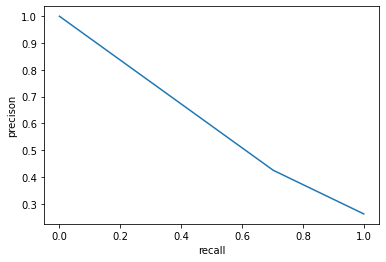

In [88]:
# look at precision recall curve
import matplotlib.pyplot as plt
import seaborn as sns

precision, recall, threshold = precision_recall_curve(df_sentences_test['has_spoiler'], probabilities_test)
fig = sns.lineplot(recall, precision)
fig.set(xlabel='recall', ylabel='precison');


In [ ]:
There is not much we can do to increase precision. 

ROC-AUC score = 0.6824982358546449


Text(0, 0.5, 'recall')

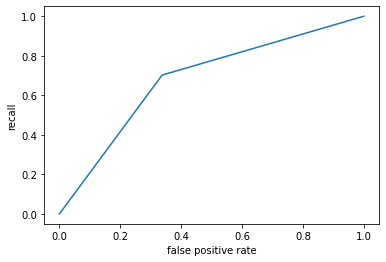

In [97]:
# Test ROC and ROC AUC
print(f"ROC-AUC score = {roc_auc_score(df_sentences_test['has_spoiler'], probabilities_test)}")

fpr, tpr, threshold = roc_curve(df_sentences_test['has_spoiler'], probabilities_test)
plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('recall')

In [108]:
# Train on safe sentences sentences
df_safe = df_crime[df_crime['has_spoiler']==False]
test_sentences = []
test_labels =[]

for review in tqdm(df_safe['sentence_text_spellchecked']):
    for sen in review:
        test_sentences.append(sen)

         
for review in tqdm(df_safe['sentence_labels']):
    for label in review:
        test_labels.append(label)

100%|██████████| 44561/44561 [00:00<00:00, 100971.82it/s]


In [111]:
len(test_sentences)

447037

In [113]:
df_crime_safe_vec = pd.DataFrame(columns = range(300))
for sen in tqdm(test_sentences):
    vec = ft.get_sentence_vector(sen)
    df_crime_safe_vec = df_crime_safe_vec.append(pd.Series(vec), ignore_index=True )

 28%|██▊       | 126686/447037 [1:55:12<4:51:19, 18.33it/s] 


KeyboardInterrupt: 

In [114]:
df_crime_safe_vec.shape

(126686, 300)

In [138]:
# put together  sentences from spoiler reviews and safe sentences
df_train_vec_new = pd.concat([df_spoiler_vec,df_crime_safe])
# add labels for sentences from safe reviews
new_labels = list(df_sentences['has_spoiler'])+[0]*df_crime_safe.shape[0]
df_train_vec_new['has_spoiler'] = new_labels
# resample data
df_train_vec_new = df_train_vec_new.sample(frac = 1)

In [155]:
test_clfs(models_imblearn, df_train_vec_new.iloc[:,:-1], df_train_vec_new['has_spoiler'], cv = 2)

Done with BalancedRandomForestClassifier
Done with Bagging-SVC
Done with Bagging-Logistic
Done with Bagging-Ridge
Done with RUSBoost


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,BalancedRandomForestClassifier(),50.223 +/- 4.61,0.68 +/- 0.003,0.673 +/- 0.008,0.191 +/- 0.0,0.747 +/- 0.001,0.545 +/- 0.001
1,BalancedBaggingClassifier(base_estimator=Linea...,24.327 +/- 0.136,0.671 +/- 0.003,0.711 +/- 0.009,0.193 +/- 0.0,0.751 +/- 0.002,0.544 +/- 0.001
2,BalancedBaggingClassifier(base_estimator=Logis...,17.759 +/- 0.048,0.66 +/- 0.001,0.72 +/- 0.007,0.189 +/- 0.001,0.747 +/- 0.002,0.537 +/- 0.0
3,BalancedBaggingClassifier(base_estimator=Ridge...,14.254 +/- 1.753,0.672 +/- 0.0,0.71 +/- 0.006,0.193 +/- 0.001,0.75 +/- 0.002,0.544 +/- 0.0
4,RUSBoostClassifier(),61.215 +/- 5.402,0.66 +/- 0.001,0.681 +/- 0.009,0.182 +/- 0.001,0.731 +/- 0.002,0.532 +/- 0.0


When using more safe sentences from the non-spoiler reviews and adding these to the spoiler review dataset, the class imbalance problem is more pronounced. While the recall of about 0.7 is still good, precission below 0.2 are not satisfactory. 

In [159]:
# using lemmatized sentences
features = ['has_spoiler','sentence_labels', 'sentence_text_spellchecked', 'lemmatized', 'best_genre']
df_train = fetch_features(training, features)
df_crime_spoiler_new = df_train[(df_train['best_genre'] == 'mystery, thriller, crime') & (df_train['has_spoiler'] == True)]

sentences = []
#
for review in tqdm(df_spoiler['sentence_text_spellchecked']):
    for sentence in review:
        sentences.append(sentence)
#
labels = []
for review in tqdm(df_spoiler['sentence_labels']):
    for label in review:
        labels.append(label)
#
#
df_sentences_lemma = pd.DataFrame({
    'has_spoiler': labels,
    'sentences': sentences
})

df_spoiler_vec_lemma = pd.DataFrame(columns = range(300))
for sen in tqdm(df_sentences_lemma['sentences']):
    vec = ft.get_sentence_vector(sen)
    df_spoiler_vec_lemma = df_spoiler_vec_lemma.append(pd.Series(vec), ignore_index=True )

964623it [05:10, 3106.37it/s] 
100%|██████████| 72719/72719 [30:41<00:00, 39.49it/s]  


In [167]:
test_clfs(models2, df_spoiler_vec_lemma, df_sentences_lemma['has_spoiler'], cv = 3)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done with SGD
Done with LinearSVC
Done with LogReg
Done with D_Tree_CLF


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,SGDClassifier(n_jobs=-1),0.887 +/- 0.064,0.724 +/- 0.0,0.0 +/- 0.0,0.333 +/- 0.471,0.733 +/- 0.005,0.42 +/- 0.0
1,"LinearSVC(max_iter=5000, random_state=42)",3.817 +/- 0.139,0.739 +/- 0.002,0.179 +/- 0.005,0.59 +/- 0.013,0.738 +/- 0.006,0.558 +/- 0.003
2,"LogisticRegression(n_jobs=-1, random_state=42)",33.713 +/- 1.753,0.74 +/- 0.002,0.179 +/- 0.003,0.595 +/- 0.011,0.738 +/- 0.006,0.558 +/- 0.002
3,"DecisionTreeClassifier(max_depth=50, random_st...",33.521 +/- 0.961,0.652 +/- 0.001,0.39 +/- 0.006,0.374 +/- 0.002,0.571 +/- 0.002,0.57 +/- 0.002


In [166]:
test_clfs(models_imblearn, df_spoiler_vec_lemma, df_sentences_lemma['has_spoiler'], cv = 3)

Done with BalancedRandomForestClassifier
Done with Bagging-SVC
Done with Bagging-Logistic
Done with Bagging-Ridge
Done with RUSBoost


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,BalancedRandomForestClassifier(),63.391 +/- 0.605,0.674 +/- 0.001,0.657 +/- 0.012,0.439 +/- 0.003,0.735 +/- 0.004,0.639 +/- 0.003
1,BalancedBaggingClassifier(base_estimator=Linea...,23.992 +/- 0.488,0.674 +/- 0.004,0.69 +/- 0.009,0.442 +/- 0.005,0.739 +/- 0.006,0.643 +/- 0.004
2,BalancedBaggingClassifier(base_estimator=Logis...,14.371 +/- 1.177,0.669 +/- 0.004,0.7 +/- 0.009,0.437 +/- 0.004,0.737 +/- 0.006,0.64 +/- 0.004
3,BalancedBaggingClassifier(base_estimator=Ridge...,6.085 +/- 0.26,0.674 +/- 0.005,0.691 +/- 0.009,0.442 +/- 0.005,0.738 +/- 0.006,0.644 +/- 0.005
4,RUSBoostClassifier(),73.7 +/- 0.174,0.657 +/- 0.007,0.667 +/- 0.013,0.423 +/- 0.008,0.72 +/- 0.008,0.625 +/- 0.007


In [183]:
# fit classifier
clf = BalancedBaggingClassifier(base_estimator=LogisticRegression(C = 0.001, max_iter = 500))
cross_validate(clf, df_spoiler_vec_lemma, df_sentences_lemma['has_spoiler'], scoring = ['recall', 'accuracy', 'precision', 'f1_macro', 'roc_auc'], 
                                 cv = 5)

clf.fit(df_spoiler_vec_lemma, df_sentences_lemma['has_spoiler'])

BalancedBaggingClassifier(base_estimator=LogisticRegression(C=0.001,
                                                            max_iter=500))

In [207]:
# prepare training set
sentences_test = []
for review in tqdm(df_test_crime_spoiler['lemmatized']):
    for sentence in review:
        sentences_test.append(sentence)
#
labels_test = []
for review in tqdm(df_test_crime_spoiler['sentence_labels']):
    for label in review:
        labels_test.append(label)
#
#
df_sentences_test_l = pd.DataFrame({
    'has_spoiler': labels_test,
    'sentences': sentences_test
})

#get sentence vectors using pretrained english word vectors
df_test_vec_l = pd.DataFrame(columns = range(300))
for sen in tqdm(df_sentences_test_l['sentences']):
    vec = ft.get_sentence_vector(sen)
    df_test_vec_l = df_test_vec_l.append(pd.Series(vec), ignore_index=True )
    
predictions_test_l = clf.predict(df_test_vec)
probabilities_test_l = clf.predict(df_test_vec)


100%|██████████| 10021/10021 [01:36<00:00, 103.57it/s]


In [185]:
confusion_matrix(df_sentences_test['has_spoiler'], predictions_test_l )

array([[4773, 2623],
       [ 884, 1741]])

In [208]:
print(classification_report(df_sentences_test['has_spoiler'], predictions_test_l ))

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      7396
           1       0.40      0.66      0.50      2625

    accuracy                           0.65     10021
   macro avg       0.62      0.65      0.61     10021
weighted avg       0.73      0.65      0.67     10021



Text(0, 0.5, 'recall')

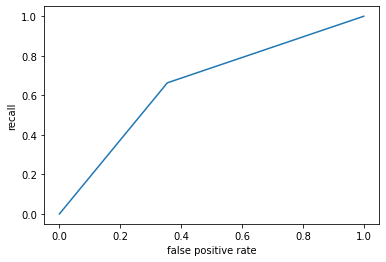

In [209]:
fpr, tpr, threshold = roc_curve(df_sentences_test['has_spoiler'], probabilities_test_l)

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('recall')

In [202]:
# try to 
df_test_crime = df_test[df_test['best_genre'] == 'mystery, thriller, crime']

probas = []
predictions = []
for review in tqdm(df_test_crime['lemmatized']):
    vecs = pd.DataFrame(columns = range(300))
    for sen in review:
        vecs = vecs.append(pd.Series(ft.get_sentence_vector(sen)), ignore_index = True)
    p = clf.predict_proba(vecs)
    predictions.append(np.max(clf.predict(vecs)))
    probas.append(np.max(p))

100%|██████████| 6817/6817 [08:24<00:00, 13.51it/s]


Text(0, 0.5, 'recall')

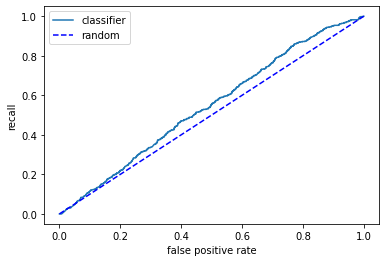

In [213]:
fpr, tpr, threshold = roc_curve(df_test_crime['has_spoiler'], probas)
plt.plot(fpr, tpr, label = 'classifier')
plt.plot([0,1], [0,1], 'b--' ,label = 'random')
plt.xlabel('false positive rate')
plt.legend()
plt.ylabel('recall')

Text(0, 0.5, 'precision')

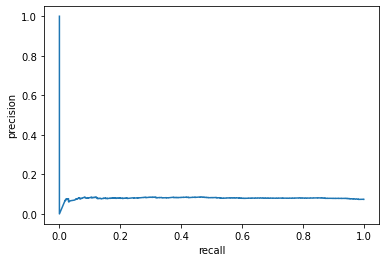

In [217]:
precision, recall, threshold = precision_recall_curve(df_test_crime['has_spoiler'], np.array(probas))

plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')

While the model shows similar recall and accuracy for training data and test spoiler review data, it fails to be generalized to non spoiler reviews. As for many other approaches we have tried in this projects, the high fals positive rate makes it difficult to get good models for spoiler and safe reviews.